# 1. Load the dataset

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

from tqdm.notebook import tqdm
import sklearn

In [2]:
from datasets.image_dataset import ImageDataset, UniformImageDataset
from datasets.study_dataset import StudyDataset
from datasets.masked_image_study_labeled_dataset import MaskedImageStudyLabeledDataset

In [3]:
image_csv = "./siim-covid19-detection/train_image_level.csv"
input_dir = "./siim-covid19-detection/train"
study_csv = "./siim-covid19-detection/train_study_level.csv"

dataset = MaskedImageStudyLabeledDataset(input_dir, image_csv, study_csv, img_size = (256, 256))

In [47]:
# remove class = 0
not_class_0 = []
for data in tqdm(dataset):
    not_class_0.append(not data[1][0])

  0%|          | 0/6334 [00:00<?, ?it/s]

In [52]:
not_class_0_ = []
for i in range(len(not_class_0)):
    if not_class_0[i]:
        not_class_0_.append(i)

In [54]:
dataset_wbb = torch.utils.data.Subset(dataset, not_class_0_)

In [55]:
len(dataset), len(dataset_wbb)

(6334, 4598)

In [5]:
6334 - 64 * 80

1214

In [6]:
train_set, val_set = torch.utils.data.random_split(dataset, [5120, 1214])

In [57]:
4598 - 64 * 60

758

In [58]:
train_set, val_set = torch.utils.data.random_split(dataset_wbb, [64 * 60 , 758])

In [59]:
dataloader_test = DataLoader(train_set, batch_size=64,
                        shuffle=True, num_workers=0)
dataloader_val = DataLoader(val_set, batch_size=64,
                        shuffle=True, num_workers=0)

# 1b alternative dataset

hier hatte ich versucht ein anderes datenset zu benutzen, als unseres noch nicht fertig war -> kann ignoriert werden

In [ ]:
# source https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

train_path = "./other_data/chest_xray/train/"
val_path = "./other_data/chest_xray/val/"
test_path = "./other_data/chest_xray/test/"

In [ ]:
from torchvision.datasets import ImageFolder
transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])
dataset = ImageFolder(root = train_path, transform= transformations)

In [ ]:
dataset

In [ ]:
dataset.classes

In [ ]:
dataloader = DataLoader(dataset, batch_size=8,
                        shuffle=True, num_workers=0)

# Looking at the data

In [8]:
key = {
    0: "Negative for Pneumonia",
    1: "Typical Appearance", 
    2: "Indeterminate Appearance",
    3: "Atypical Appearance"
}

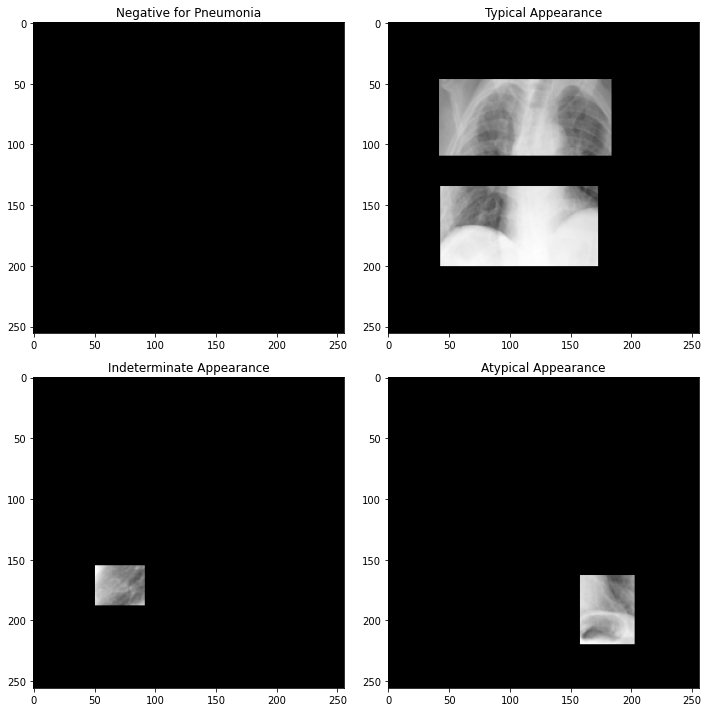

In [9]:
fig, ax = plt.subplots(2, 2, figsize = (10,10))
for i in range(4):
    for img, label in dataset:
        if label[i]:
            a = ax[i//2, i%2]
            a.set_title(key[i])
            a.imshow(transforms.ToPILImage()(img), cmap = "gray")
            break
fig.tight_layout()
plt.show()

# 2. Create Network

For every image there needs
    - be bounding boxes of anomalies found
    - type classified
    
We decided to split those two tasks into two networks

Shape change with different layers:

input_size = H_in x W_in
no of channels = C_in (black and white -> C_in = 1)
batch_size = B

Kernel_shape: KxK (only consider quadratic)
output_shape: H_out x W_out
no of channels = C_out

Conv2d (C_in, C_out, K):
(here i do not use some options of conv2d)
H_out = H_in - K + 1
W_out = W_in - K + 1
=> input (B, C_in, H_in, W_in) --> output (B, C_out , H_in - K + 1, W_in - K +1)

Maxpool2d(K,K):
K: Kernel size = Stride
H_out = floor((H_in -2 + K) / K)
(eventuell rounded down)
=> input (B, C_in, H_in, W_in) --> output (B, C_in, (H_in + K - 2) / K , (W_in + K -2)/ K)

In [89]:
class Classifier1(nn.Module):
    def __init__(self, input_size = 256, ):
        super().__init__()
        
        
        
        #self.block1 = nn.Sequential(
        #    nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5,5)),
        #    nn.MaxPool2d(2, 2),
        #    nn.Conv2d(6, 16, 5),
        #)
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 5)
        
        after_conv_size = int((input_size / 4 - 7)**2  * 32)
        self.fc1 = nn.Linear(after_conv_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        # B:= Batchsize
        # Inputsize: HxW
        # shape x: (B, 1, H, W)
        
        x = self.conv1(x)  # shape: (B, 6, H - 4 , W - 4 )
        x = self.pool1(x)  # shape: (B, 6, H/2 -2 , W/2 -2 )
        x = self.conv2(x)  # shape: (B, 16, H/2 - 6, W/2 - 6)
        x = self.pool2(x)  # shape: (B, 16, H/4 - 3, W/4 - 3 )
        x = self.conv3(x)  # shape: (B, 32, H/4 - 7 , W/4 - 7)
        x = torch.flatten(x, 1) # shape: (B, rest)
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Classifier1()

In [10]:
class Classifier2(nn.Module):
    def __init__(self, input_size = 256, ):
        super().__init__()
        
        
        
        #self.block1 = nn.Sequential(
        #    nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5,5)),
        #    nn.MaxPool2d(2, 2),
        #    nn.Conv2d(6, 16, 5),
        #)
        
        self.conv1 = nn.Conv2d(1, 16, 3) 
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(32, 32, 3)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(32, 64, 3)
        
        after_conv_size = int((input_size / 16 - 4)**2  * 64)
        self.fc1 = nn.Linear(after_conv_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        # B:= Batchsize
        # Inputsize: HxW
        # shape x: (B, 1, H, W)
        
        x = self.conv1(x)  # shape: (B, 16, H - 2 , W - 2 )
        x = self.pool1(x)  # shape: (B, 16, H/2 - 1 , W/2 - 1 )
        
        x = F.relu(x)
        x = self.conv2(x)  # shape: (B, 16, H/2 - 3, W/2 - 3)
        x = self.pool2(x)  # shape: (B, 16, H/4 - 2, W/4 - 2)
        
        x = F.relu(x)
        x = self.conv3(x)  # shape: (B, 32, H/4 - 4 , W/4 - 4)
        x = self.pool3(x)  # shape: (B, 32, H/8 - 2 , W/8 - 2)
        
        x = F.relu(x)
        x = self.conv4(x)  # shape: (B, 32, H/8 - 4 , W/8 - 4)   
        x = self.pool4(x)  # shape: (B, 32, H/16 - 2 , W/16 - 2)
        
        x = F.relu(x)
        x = self.conv5(x)  # shape: (B, 64, H/16 - 4 , W/16 - 4)
        
        x = torch.flatten(x, 1) # shape: (B, rest)
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Classifier2()

In [13]:
net.load_state_dict(torch.load("./vanilla_cnn_e10.ckpt"))

<All keys matched successfully>

In [15]:
for x,y in dataloader_test:
    net(x)
    break

In [14]:
net

Classifier2(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

In [31]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
#scheduler = ReduceLROnPlateau(optimizer, 'min')

In [32]:
all_loss = 0
i = 0
for e in range(num_epochs): 
    print("epoch " + str(e))
    for x,y in tqdm(dataloader_test):
        optimizer.zero_grad()
        y = torch.argmax(y.float(), dim = 1)
        output = net(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        all_loss += loss.item()
        
        if i%10 == 0:
            print(all_loss/ 10)
            all_loss = 0
        i += 1

epoch 0


  0%|          | 0/80 [00:00<?, ?it/s]

0.1424034595489502
2.548920053243637
1.2810815930366517
1.1069117188453674
0.8470125734806061
0.7452528834342956
0.7081866532564163
0.7204595863819122
epoch 1


  0%|          | 0/80 [00:00<?, ?it/s]

1.026108878850937
1.187977248430252
1.208035373687744
1.089005047082901
1.011545902490616
0.9333789050579071
0.9304863810539246
0.7387783020734787
epoch 2


  0%|          | 0/80 [00:00<?, ?it/s]

1.1156413733959198
0.920101422071457
0.8454896330833435
0.817223209142685
0.7191662430763245
0.9431368052959442
0.8395173966884613
0.7713059306144714
epoch 3


  0%|          | 0/80 [00:00<?, ?it/s]

0.7898657500743866
0.7709000468254089
2.139925849437714
1.1212849378585816
0.8126464724540711
0.9638755857944489
0.7516742289066315
0.7815170228481293
epoch 4


  0%|          | 0/80 [00:00<?, ?it/s]

0.737464714050293
0.7921542167663574
0.7313991487026215
0.658034011721611
0.6780172884464264
0.6330986797809601
0.7052156269550324
0.6002296388149262
epoch 5


  0%|          | 0/80 [00:00<?, ?it/s]

0.6631337493658066
0.6370306134223938
0.6266107320785522
0.5842897295951843
0.6587143242359161
0.6357348799705506
0.5849950939416886
0.6028582692146301
epoch 6


  0%|          | 0/80 [00:00<?, ?it/s]

0.6255044341087341
0.5838682144880295
0.6690323024988174
0.6375438719987869
0.671019047498703
0.5668075621128082
0.5684023559093475
0.6144188523292542
epoch 7


  0%|          | 0/80 [00:00<?, ?it/s]

0.5414590686559677
0.5707532405853272
0.5485950708389282
0.5297573298215866
0.5448391258716583
0.5472289800643921
0.5102921307086945
0.625950676202774
epoch 8


  0%|          | 0/80 [00:00<?, ?it/s]

0.5885129809379578
0.5301316469907761
0.5131196826696396
0.5593458831310272
0.5828542530536651
0.5890063673257828
0.4513217180967331
0.5675531476736069
epoch 9


  0%|          | 0/80 [00:00<?, ?it/s]

0.5100332140922547
0.544930949807167
0.510865044593811
0.48429928421974183
0.5515181541442871
0.5485132157802581
0.5535015881061554
0.5780603379011154


In [48]:
epoch = 10
name = "vanilla_cnn"
torch.save(net.state_dict(), f'./{name}_e{epoch}.ckpt')

In [15]:
from sklearn.metrics import confusion_matrix

In [34]:
net.eval()
acc = 0
y_true = []
y_pred = []

with torch.no_grad():
    for x,y in tqdm(dataloader_val):
        y = torch.argmax(y.float(), dim = 1)
        output = net(x)
        output = torch.argmax(output, dim = 1)
        y_true.extend(y.tolist())
        y_pred.extend(output.tolist())
        acc += sum(output == y)
        #loss = criterion(output, y.float())
        #all_loss += loss.item()
print("overall correctly classified: " + str(acc / len(val_set)))
confusion_matrix(y_true, y_pred)

  0%|          | 0/19 [00:00<?, ?it/s]

overall correctly classified: tensor(0.8410)


array([[330,   0,   0,   0],
       [ 29, 556,  10,   0],
       [ 14,  57, 133,   0],
       [ 23,  17,  43,   2]])

In [39]:
acc/len(val_set)

tensor(0.8138)

In [42]:
output == y

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True, False,  True,
         True, False, False,  True,  True, False,  True, False,  True, False,
        False,  True,  True,  True, False, False,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
        False,  True])

In [40]:
output

tensor([0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 2, 1, 1,
        0, 0, 0, 0, 1, 2, 1, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0,
        2, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 1, 1, 0])

In [41]:
y

tensor([0, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 3, 2, 1, 3, 3, 1, 0, 3, 0, 1, 1, 1, 3, 0, 0, 0, 3, 3, 0, 0,
        2, 1, 1, 0, 2, 0, 2, 1, 1, 1, 0, 1, 2, 0])